## Library Imports

In [1]:
import os
from langchain_groq import ChatGroq
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts.prompt import PromptTemplate

from dotenv import load_dotenv
from tavily import TavilyClient

_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory = SqliteSaver.from_conn_string(":memory:")

## Env Set Up

In [3]:
os.environ['OPENAI_API_KEY']=os.getenv("OPENAI_API_KEY")
groq_api_key=os.getenv('GROQ_API_KEY')
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [4]:
model_0 = ChatGroq(groq_api_key=groq_api_key,
             model_name="llama3-groq-70b-8192-tool-use-preview", temperature=0.8)
model_1 = ChatGroq(groq_api_key=groq_api_key,
             model_name="llama3-groq-8b-8192-tool-use-preview", temperature=0.3)
model_2 = ChatGroq(groq_api_key=groq_api_key, 
                model_name="llama3-70b-8192", temperature=0.2)
model_3 = ChatGroq(groq_api_key=groq_api_key,
                model_name="llama3-8b-8192", temperature=0.2)


In [5]:
embeddings = OpenAIEmbeddings()

## Doc Retrieval System

In [6]:
# # loading the text file 
# text = TextLoader("hidroelectrica_content.txt")
# document = text.load()

In [7]:
# # text splitter
# splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
# # initiating the splitter
# docs = splitter.split_documents(document)

In [8]:
# # using faiss for embedding
# vec_db = FAISS.from_documents(docs, embeddings)

In [9]:
# print(vec_db.index.ntotal)

In [10]:
# # saving the vector database
# vec_db.save_local("faiss_index")

In [11]:
# Loading the vector database
vec_db = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)

In [12]:
query = "ProfilDespre noiProfilMisiune"
query_docs = vec_db.similarity_search(query)

In [13]:
query_docs

[Document(page_content='Vintila Marius StefanDespre noiProfilMisiune, viziune si valoriPrezentariPremiiMuzeeConducereStrategieGuvernanta corporativaResponsabilitate SocialaSistem Management IntegratTrofeul EnergeticianuluiEducatie si culturaOameni si pasiuniProiecteContactProducere energieProducere energie electricaDezvoltareFurnizare energieClient CasnicClient BusinessLegislatie Furnizare Energie ElectricaRaportariSucursaleSH BistritaSH ClujSH Curtea de ArgesSH HategSH Portile de FierSH Ramnicu ValceaSH SebesSH Wind ConstantaRelatia cu investitoriiRezultate si rapoarteGuvernanta corporativaAdunarea Generala a ActionarilorDividendeOferta publica de vanzareCalendar si evenimenteContactInformatii de interes publicOferta tip pentru clienti casniciAnunturi publiceCariereAchizitii sectorialeRaportari contracte achizitie publicaIndicatori de performantaLicenteEtichete de energie electricaLegislatiePrincipii derivate din CEDORegulament CTEModel solicitare acces in obiectiveFormular solicitare

In [14]:
import re
def remove_symbols(text):
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    return cleaned_text

In [15]:
def most_similar_document(query: list) -> list:
    all_docs = []
    query = list(set(query))
    for doc in query:
        query_docs = vec_db.similarity_search(doc)
        docs = [remove_symbols(i.page_content) for i in query_docs[:1]]
        all_docs.extend(docs)
    return all_docs

# Testing the function
most_similar_document(query=["ProfilDespre noiProfilMisiune"])


['Vintila Marius StefanDespre noiProfilMisiune viziune si valoriPrezentariPremiiMuzeeConducereStrategieGuvernanta corporativaResponsabilitate SocialaSistem Management IntegratTrofeul EnergeticianuluiEducatie si culturaOameni si pasiuniProiecteContactProducere energieProducere energie electricaDezvoltareFurnizare energieClient CasnicClient BusinessLegislatie Furnizare Energie ElectricaRaportariSucursaleSH BistritaSH ClujSH Curtea de ArgesSH HategSH Portile de FierSH Ramnicu ValceaSH SebesSH Wind ConstantaRelatia cu investitoriiRezultate si rapoarteGuvernanta corporativaAdunarea Generala a ActionarilorDividendeOferta publica de vanzareCalendar si evenimenteContactInformatii de interes publicOferta tip pentru clienti casniciAnunturi publiceCariereAchizitii sectorialeRaportari contracte achizitie publicaIndicatori de performantaLicenteEtichete de energie electricaLegislatiePrincipii derivate din CEDORegulament CTEModel solicitare acces in obiectiveFormular solicitare']

## Chat Agent

### Input: 
- Question/Query
- Correst response/answer.


### Process
- Question --- User Question.
- Query Reviewer + MultiQuery --- creatign new or similar questions. 
- Draft --- Answer based on RAG documents.
- Critique --- Checking is the question is answered correctly.
- Content --- The newest answer.
- Revision Number --- Number of revisions made
- Max Revision --- The max number of revisions made while processing the post.

In [16]:
class ChatAgentState(TypedDict):
    question: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

## Helper function and prompts

In [17]:
def doc_organizer(question: str, docs: list) -> str:
    
    template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are an expert at Answering Questions.
    Background: The user is interested in knowing some information about the company Hidroelectrica. \n
    The user loves the company so much and wants to know more about it. \n


    The user asked the questions in USER_QUESTION. \n
    The database content is in Romanian. \n The retrieved documents are in RETRIEVED_DOCUMENTS. \n
    
    The retrieved documents are in Romanian. \n
    
    Here's your task: \n
        1. Translate the documents to English. \n
        2. Filter the translated document to keep only those related to the user \n
    
    As output return only parts that are related the question in one paragraph. \n
        
    Please only return the needed paragraph. No extra explanation.. Just that paragraph without any explanation. \n
    Your output should be in English. \n
    
    
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    USER_QUESTION: {question}
    RETRIEVED_DOCUMENTS: {docs}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    AI Assistant:"""

    question_prompt = PromptTemplate(input_variables=["question", "docs"], template=template)
    initiator_router = question_prompt | model_0 | StrOutputParser()
    output = initiator_router.invoke({"question":question, "docs":docs})
    return output

In [18]:
def multi_query_generator(question: str) -> str:
    
    template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are an expert at Reviewing Questions.
    Background: The user is interested in knowing some information about the company Hidroelectrica. \n
    The client loves the company so much and wants to know more about it. \n


    The client will send in a question, your job is to review the question and create text sub-questions. \n The sub-questions are -questions written in a better and critical way to get more answers. 
    The database content is in  Romanian. Your job is to create two sub-questions in romanian \n
    Make sure the sub-questions are relevant to the client's question. \n

    Output format : [sub-questions1, sub-questions2] \n
    Return only the output without any additional information. \n
    
    
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    USER_QUESTION: {question}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    AI Assistant:"""

    question_prompt = PromptTemplate(input_variables=["question"], template=template)
    initiator_router = question_prompt | model_2 | StrOutputParser()
    output = initiator_router.invoke({"question":question})
    return output

In [19]:
question = "What is the mission of Hidroelectrica?"
questions = multi_query_generator(question)
print(questions)

[Care sunt obiectivele principale ale misiunii Hidroelectrica?, Cum contribuie misiunea Hidroelectrica la dezvoltarea durabilă a României?]


In [20]:
docs = most_similar_document(query=questions)
print(docs)

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'de esalon inferior reusea sa sio tempereze avand un statut privilegiat sub arme Insa la acel moment un context nefavorabil avea sai inchida toate caile de scapare chiar daca pareau una mai landemana ca alta cei de la Politehnica nau reusit sal tina la Iasi cei de la Steaua care era echipa armatei voiau sal transfere dar atunci nu au putut so faca nici macar echipa locala Chimia Turnu Magurele care era divizionara B na izbutit sasi asigure serviciile sale A fost un preambul parca la ceea ce avea sa pateasca ceva mai tarziu cariera sa Necazul na venit atat de la faptul ca a trait in mediu cazon in respectiva perioada cat de la inactivitatea care la scos din forma sportiva si din circuitul fotbalului trebuind sa munceasca timp indelungat pentru asi reveni completPe langa Steaua si Dinamo sa aratat interesata in al transfera Peatunci spre deosebire de azi atunci cand cele doua cluburi ale uniformelor 

In [21]:
print(doc_organizer(question, docs))

The mission of Hidroelectrica is to produce and distribute electricity efficiently, providing sustainable energy solutions to the Romanian market.


In [22]:
# Combining the two functions
def rag_agent(question: str) -> str:
    # generating sub-questions
    questions = multi_query_generator(question)
    # retrieving documents
    docs = most_similar_document(query=questions)
    # generating response
    response = doc_organizer(question, docs)
    return response

In [23]:
PLAN_PROMPT = """You are an chat expert good with creating a high level chat conversation with a user. You are tasked with writing and crafting a high level outline on how to answer a user question. \
Background: The user is interested in knowing some information about the company Hidroelectrica. \
The user loves the company so much and wants to know more about it. \
    
You observe the user question, then create an outline on the best way of answering the question \
This outline will serve as a plan on how to answer the question correctly. \
Give an outline of the answer along with any relevant notes or instructions on the answer tone and uniqueness.\
Please make it short and concise. \
"""

In [24]:
# DOCUMENT_PROMPT = """
# You are a document ai responsible for gathering information and making a good sense out of it. \n
# You're given a list of documents extracted from a database, the document language is in Romanian. \n
# Your job is to read the documents, convert it to English, and write it properly. \n
# Utilize all the information below as needed. \n

# -------

# {document}
# """

In [25]:
WRITER_PROMPT = """You are a chat ai agent tasked with review chat messages response to the user.\
Generate the best answer possible for the user's question and the initial response. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [26]:
REFLECTION_PROMPT = """You are a teacher grading a chat response. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for tone, length, depth, style, etc."""

In [27]:
RESEARCH_PLAN_PROMPT = """You are a chat researcher charged with providing information that can \
be used when composing the a better chat response. Generate a list of search queries that will gather \
any relevant information. Only generate 2 queries max. it should be relevant to the response and the user's question.\
If there's no need for a query, respond with "None".    
"""


In [28]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


## Agent Nodes

In [29]:
from langchain_core.pydantic_v1 import BaseModel
import time

class Queries(BaseModel):
    queries: List[str]

In [30]:
def plan_node(state: ChatAgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['question'])
    ]
    response = model_0.invoke(messages)
    return {"plan": response.content}

In [31]:
# def rag_node(state: ChatAgentState):
#     messages = [
#         SystemMessage(content=QUERY_REVIEWER_PROMPT), 
#         HumanMessage(content=state['question'])
#     ]
#     content = state['content'] or []
#     response = model.invoke(messages)
#     # generating similar documents
#     docs = most_similar_document(response.content)
#     # generating the answer
#     answer = doc_organizer(question=state['question'], docs=docs)
#     # appending the answer to the content
#     content.append(answer)
#     return {"content": content}

In [32]:
def research_plan_node(state: ChatAgentState):
    
    # getting the rag document
    rag_doc = rag_agent(state['question'])
    
    content = state['content'] or []
    # adding the rag document to the content
    content.append(rag_doc)
    
    # creating the queries
    queries = model_3.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['question'])
    ])
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [33]:
def generation_node(state: ChatAgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['question']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model_0.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [34]:
def reflection_node(state: ChatAgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model_2.invoke(messages)
    return {"critique": response.content}

In [35]:
def research_critique_node(state: ChatAgentState):
    queries = model_1.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [36]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

## Building the Agent

In [37]:
# Initialize the graph
builder = StateGraph(ChatAgentState)

In [38]:
# Setting the graph nodes
builder.add_node("planner", plan_node)
# builder.add_node("rag", rag_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [39]:
# Starting to build the graph
# setting the entry point
builder.set_entry_point("planner")

In [40]:
# adding the rag node
# builder.add_edge("planner", "rag")

In [41]:
# setting the conditional edge
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)

In [42]:
# Connecting the remaining nodes
# rag -> research_plan -> generate -> reflect -> research_critique -> generate
builder.add_edge("planner", "research_plan")
# research_plan -> generate 
builder.add_edge("research_plan", "generate")
# generate --> Conditional node  --> reflect -> research_critique
builder.add_edge("reflect", "research_critique")
# research_critique -> generate
builder.add_edge("research_critique", "generate")

In [43]:
graph = builder.compile(checkpointer=memory)

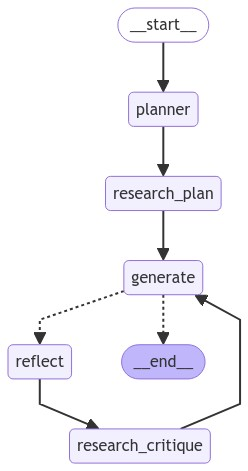

In [51]:
from IPython.display import Image

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [45]:
# thread setup
thread = {"configurable": {"thread_id": "1"}}

In [52]:
# combining the instruction and the post
question = f"Hello there."

# starting the thread
for s in graph.stream({
    'question': question,
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'planner': {'plan': 'Hello! How can I assist you today?'}}
{'research_plan': {'content': ["Hidroelectrica's mission is to generate electricity efficiently and sustainably, providing a reliable source of energy to the Romanian market while also being committed to environmental protection and social responsibility.", 'Hidroelectrica is a leader in electricity production and the main provider of technological services required in the National Energy System in Romania. The company is currently managed in a dual system, by a Management Board, under the supervision of a Supervisory Board. History', 'S.C. Hidroelectrica. Established in 2000, Hidroelectrica occupies a key position in the Romanian energy market owing to its experience, credibility and flexibility. It is the leading energy generator and supplier in Romania and the main provider of ancillary services. With an average output of 17 TWh, generated in its subsidiaries strategically ...', 'Misiunea Hidroelectrica este aceea de a crea

In [53]:
print(s['generate']['draft'])

Of course! How can I assist you today?
